# TP5: Training Tricks

See also 
[Karpathy's blog on training tricks](https://karpathy.github.io/2019/04/25/recipe/)

In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter

In [40]:
# Load CIFAR10 dataset and define a transformation done on all images:
# - resize to 32x32 (does nothing here)
# - convert to tensor
# - normalize to mean 0.5, std 0.5 for each channel
transform = transforms.Compose(
    [transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

print(f"Train points {len(trainset)}")
print(f"Test points {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Train points 50000
Test points 10000


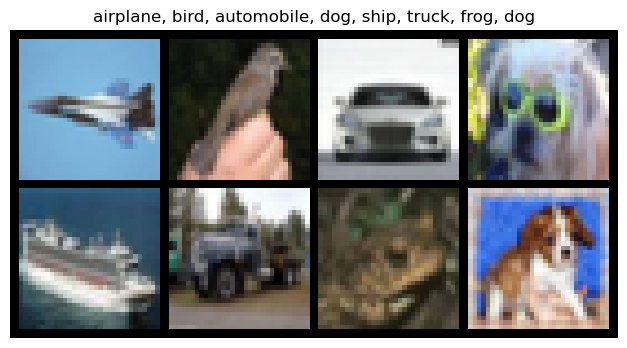

Number of classes: 10
Image shape: torch.Size([3, 32, 32])


In [41]:
# show a few images from the training loader
train_dl = DataLoader(trainset, batch_size=8, shuffle=True)
imgs, labels = next(iter(train_dl))
imgs = imgs[:8] * 0.5 + 0.5
grid = make_grid(imgs, nrow=4)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(", ".join([trainset.classes[int(ell)] for ell in labels[:8]]))
plt.show()

print(f"Number of classes: {len(trainset.classes)}")
# print(f"Classes: {trainset.classes}")
print(f"Image shape: {imgs[0].shape}")  # C, H, W

# Our Base Model

In [42]:
# Our baseline model
class CNN_base(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        channels = [3, 32, 64, 128, 128, 256]
        layers = []
        for i in range(5):
            layers += [
                nn.Conv2d(channels[i], channels[i + 1], 3, padding=1),
                nn.ReLU(),
            ]
            if i in {1, 3, 4}:  # downsample after 2nd, 4th, and 5th conv
                layers.append(nn.MaxPool2d(2, 2))
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_train = 200
train_subset = Subset(trainset, list(range(n_train)))
train_dl = DataLoader(train_subset, batch_size=32, shuffle=True)
test_dl = DataLoader(testset, batch_size=4)

writer = SummaryWriter("runs/")

# log a small batch of images and the model graph (if possible)
imgs_sample, labels_sample = next(iter(train_dl))
imgs_sample = imgs_sample.to(device)
# writer.add_graph(model, imgs_sample)  # may fail for some models
grid = make_grid(imgs_sample[:16], nrow=4, normalize=True, scale_each=True)
writer.add_image("train/sample_images", grid)

# Our Training Set 
We focus on a tiny subset of CIFAR to test optimization on a simplet setup.
Normally, we should end up overfitting this small training set quickly. 

In [44]:
n_train = 100
train_subset = Subset(trainset, list(range(n_train)))
train_dl = DataLoader(train_subset, batch_size=32, shuffle=True)

# Some utility functions to log info during training


In [ ]:
def log_grad_norms(model, writer, step, model_name=""):
    for param_name, p in model.named_parameters():
        if p.grad is not None:
            writer.add_scalar(
                f"{model_name}/grads/{param_name}", p.grad.norm().item(), step
            )


def get_layer_grad_norms(model):
    layer_norms = defaultdict(float)
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        layer_norms[name] += p.grad.norm().item() ** 2
    return {k: v**0.5 for k, v in layer_norms.items()}

# Training Loop

Use [https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html](tensorboard)
to monitor training.
Logging and visualizing training info is very important to understand what is going on 
and debug your code.

In [46]:
def test_model(model, test_dl, criterion, writer=None, global_step=None, name=""):
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for imgs, labels in test_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=-1)
            loss = criterion(logits, labels)
            losses.append(loss)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    if writer is not None and global_step is not None:
        writer.add_scalar(f"{name}/test/accuracy", 100 * correct / total, global_step)
        writer.add_scalar(f"{name}/test/loss", np.mean(losses), global_step)
    print(f"Test accuracy: {100 * correct / total:.2f}%, test loss: {np.mean(losses)}")

In [ ]:
def train(
    model,
    train_dl,
    opt,
    criterion,
    writer,
    n_epochs,
    name="",
    global_step=0,
    prints=False,
):
    for epoch in range(n_epochs):
        model.train()
        for imgs, labels in train_dl:
            global_step += 1
            imgs, labels = imgs.to(device), labels.to(device)
            # forward
            opt.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            writer.add_scalar(f"{name}/train/cnn_loss", loss.item(), global_step)
            loss.backward()
            if global_step % 10 == 0:
                log_grad_norms(model, writer, global_step, model_name=name)
            opt.step()
        print(f"Epoch {epoch + 1}: train loss = {loss.item():.4f}")
        if prints:
            print(get_layer_grad_norms(model))
        model.eval()
        test_model(
            model, test_dl, criterion, writer=writer, global_step=global_step, name=name
        )

# Sigmoid activation

In [48]:
# Try sigmoid
class CNN5_sigmoid(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        channels = [3, 32, 64, 128, 128, 256]
        layers = []
        for i in range(5):
            layers += [
                nn.Conv2d(channels[i], channels[i + 1], 3, padding=1),
                nn.Sigmoid(),
            ]
            if i in {1, 3, 4}:  # downsample after 2nd, 4th, and 5th conv
                layers.append(nn.MaxPool2d(2, 2))
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [49]:
n_train = 200
train_subset = Subset(trainset, range(n_train))
train_dl = DataLoader(train_subset, batch_size=32, shuffle=True)

cnn_sig = CNN5_sigmoid().to(device)
total_params = sum(p.numel() for p in cnn_sig.parameters())
print(f"Training SimpleCNN model with {total_params} parameters")

opt = torch.optim.Adam(cnn_sig.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

param_name = "sig_act"
n_epochs = 50

train(
    cnn_sig, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0
)

Training SimpleCNN model with 576970 parameters
Epoch 1: train loss = 2.6902
Test accuracy: 10.00%, test loss: 2.3873987197875977
Epoch 2: train loss = 2.3897
Test accuracy: 10.00%, test loss: 2.3811380863189697
Epoch 3: train loss = 2.2784
Test accuracy: 10.00%, test loss: 2.3960156440734863
Epoch 4: train loss = 2.2894
Test accuracy: 10.00%, test loss: 2.367581367492676
Epoch 5: train loss = 2.1007
Test accuracy: 10.00%, test loss: 2.3396012783050537
Epoch 6: train loss = 2.4759
Test accuracy: 10.00%, test loss: 2.3421664237976074
Epoch 7: train loss = 2.2074
Test accuracy: 10.00%, test loss: 2.3460395336151123
Epoch 8: train loss = 2.3308
Test accuracy: 10.00%, test loss: 2.3453757762908936
Epoch 9: train loss = 2.3822
Test accuracy: 10.00%, test loss: 2.3273234367370605
Epoch 10: train loss = 2.3915
Test accuracy: 10.00%, test loss: 2.3181378841400146
Epoch 11: train loss = 2.4792
Test accuracy: 10.00%, test loss: 2.325214385986328
Epoch 12: train loss = 2.3694
Test accuracy: 10.00

[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

# Compare to initial

In [50]:
param_name = "baseline"
cnn = CNN_base().to(device)
total_params = sum(p.numel() for p in cnn.parameters())
print(f"Training SimpleCNN model with {total_params} parameters")

opt = torch.optim.Adam(cnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(cnn, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0)

Training SimpleCNN model with 576970 parameters
Epoch 1: train loss = 2.3882
Test accuracy: 10.00%, test loss: 2.3046722412109375
Epoch 2: train loss = 2.3319
Test accuracy: 10.00%, test loss: 2.297140121459961
Epoch 3: train loss = 2.1656
Test accuracy: 10.04%, test loss: 2.299379587173462
Epoch 4: train loss = 2.4786
Test accuracy: 15.12%, test loss: 2.2554659843444824
Epoch 5: train loss = 2.2681
Test accuracy: 15.72%, test loss: 2.180325746536255
Epoch 6: train loss = 1.9875
Test accuracy: 19.85%, test loss: 2.1370043754577637
Epoch 7: train loss = 2.0187
Test accuracy: 24.45%, test loss: 2.1495108604431152
Epoch 8: train loss = 1.6145
Test accuracy: 24.37%, test loss: 2.089271068572998
Epoch 9: train loss = 2.2851
Test accuracy: 25.70%, test loss: 2.173452377319336
Epoch 10: train loss = 2.2119
Test accuracy: 27.34%, test loss: 2.0871355533599854
Epoch 11: train loss = 1.5571
Test accuracy: 23.10%, test loss: 2.358518362045288
Epoch 12: train loss = 1.2972
Test accuracy: 26.61%, t

### Visualize the kernel weights and images

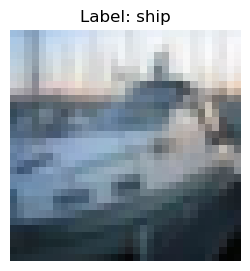

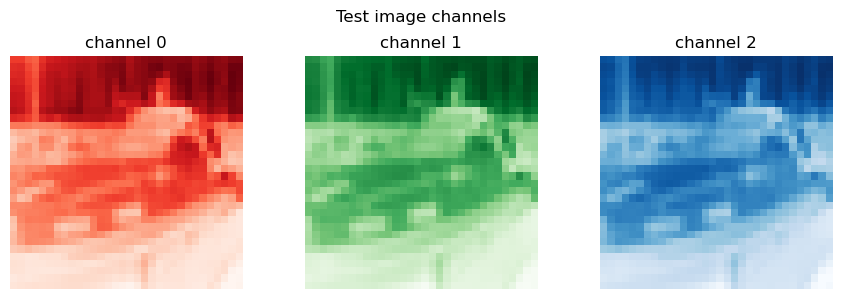

Predicted class: truck


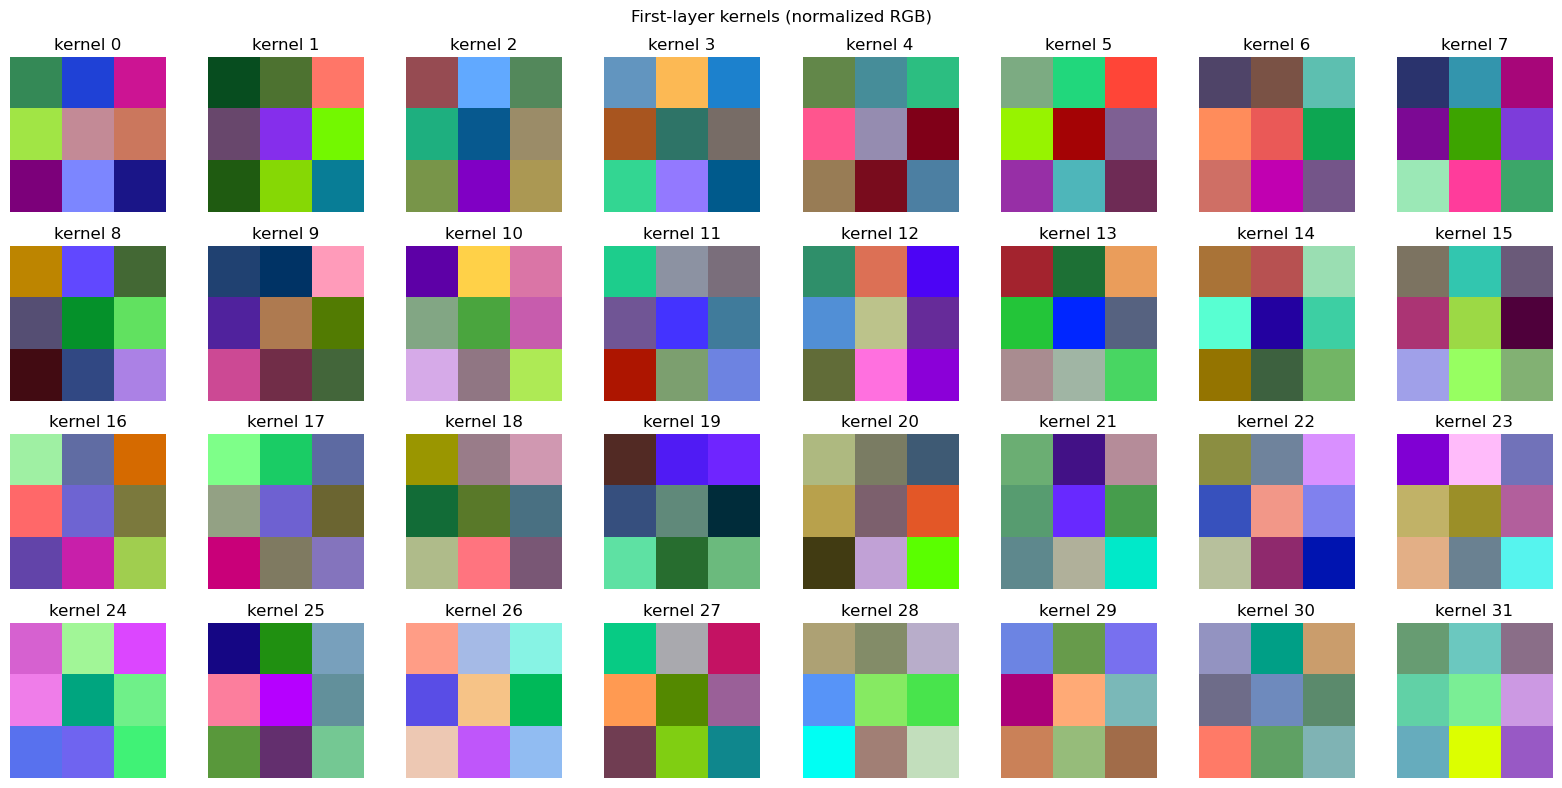

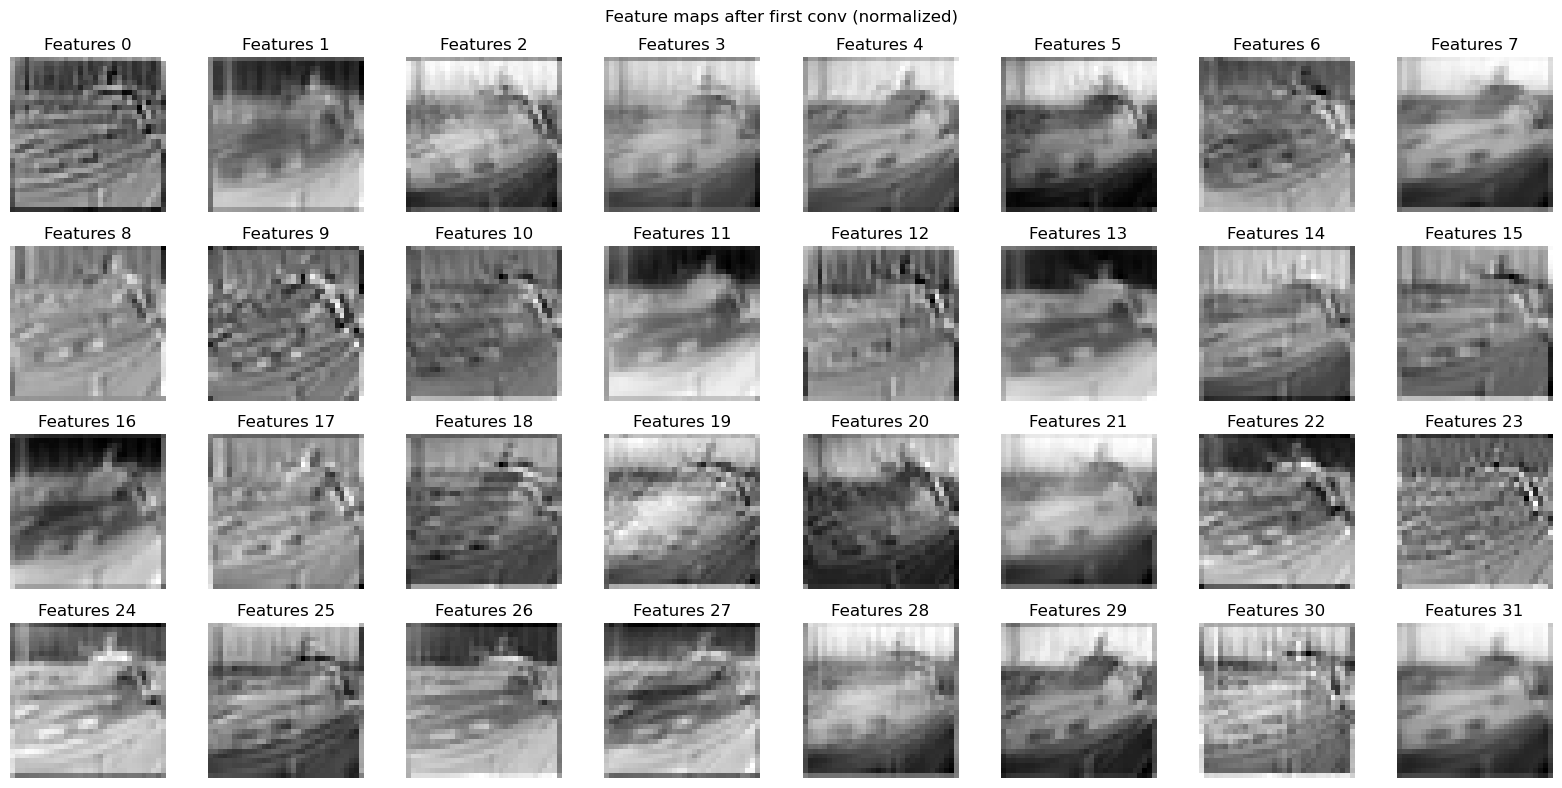

In [88]:
# visualize first-layer kernels and their feature maps on a test image


def plot_filters(model, test_dl, i_img=0):
    # get one batch from test loader and pick first image
    imgs_test, labels_test = next(iter(test_dl))
    i_test = i_img
    img = imgs_test[i_test].to(device)  # shape (1,3,32,32)
    # show the three channels side-by-side
    img_cpu = img.squeeze(0).cpu()  # (3,H,W)
    # show full RGB image (denormalize from Normalize((0.5,), (0.5,)))
    img_rgb = img_cpu.permute(1, 2, 0).numpy()
    img_rgb = np.clip(img_rgb * 0.5 + 0.5, 0, 1)
    plt.figure(figsize=(3, 3))
    plt.imshow(img_rgb)
    plt.title(f"Label: {testset.classes[labels_test[i_test]]}")
    plt.axis("off")
    plt.figure(figsize=(9, 3))

    cmaps = ["Reds", "Greens", "Blues"]
    for i in range(3):
        ch = img_cpu[i].numpy()
        ch = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)  # normalize for display
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(ch, cmap=cmaps[i])
        ax.set_title(f"channel {i}")
        ax.axis("off")
    plt.suptitle("Test image channels")
    plt.tight_layout()
    plt.show()

    pred = torch.argmax(model(img.unsqueeze(0)), dim=-1).squeeze(0)
    print(f"Predicted class: {trainset.classes[pred]}")

    conv1 = model.features[0]  # first Conv2d layer
    kernels = conv1.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
    out_ch = kernels.shape[0]

    # number of kernels / feature maps to show
    n_show = 32
    n_cols = 8
    n_rows = math.ceil(n_show / n_cols)

    # plot kernels as RGB images (normalize per-kernel)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_show):
        k = kernels[i]  # (3, kH, kW)
        k_min, k_max = k.min(), k.max()
        k_img = (k - k_min) / (k_max - k_min + 1e-8)  # normalize to 0-1
        k_img = k_img.permute(1, 2, 0).numpy()  # H,W,C
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(k_img)
        ax.set_title(f"kernel {i}")
        ax.axis("off")
    plt.suptitle("First-layer kernels (normalized RGB)")
    plt.tight_layout()
    plt.show()

    # compute feature maps produced by conv1 for the chosen test image
    with torch.no_grad():
        acts = conv1(img).squeeze(0).cpu()  # (out_ch, H, W)

    # plot first n_show feature maps (grayscale)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_show):
        act = acts[i].numpy()
        # normalize each activation map for visualization
        act = (act - act.min()) / (act.max() - act.min() + 1e-8)
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(act, cmap="gray")
        ax.set_title(f"Features {i}")
        ax.axis("off")
    plt.suptitle("Feature maps after first conv (normalized)")
    plt.tight_layout()
    plt.show()


plot_filters(cnn, test_dl, i_img=2)

### Visualize weight magnitudes

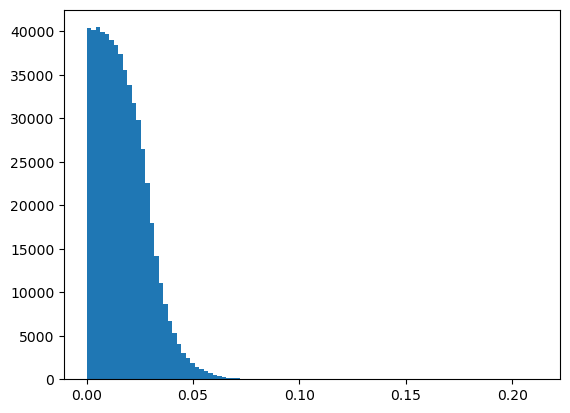

In [ ]:
def plot_weights_hist(model):
    model_weights = []
    with torch.no_grad():
        for p in model.parameters():
            model_weights.append(p.view(-1).abs())

        model_weights = torch.cat(model_weights).numpy()

    plt.hist(model_weights, bins=100)
    plt.show()


plot_weights_hist(cnn)

# Initialization Matters

### Zero Initialization
Gradients are all the same for all weights in a layer: no learning can occur. 

In [62]:
param_name = "zero_init"
cnn = CNN_base().to(device)

# initialize all weights and biases to zero

for p in cnn.parameters():
    p.data.zero_()

print("Initialized all cnn parameters to zero.")

total_params = sum(p.numel() for p in cnn.parameters())
print(f"Training SimpleCNN model with {total_params} parameters")

opt = torch.optim.Adam(cnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(cnn, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0)

Initialized all cnn parameters to zero.
Training SimpleCNN model with 576970 parameters
Epoch 1: train loss = 2.3027
Test accuracy: 10.00%, test loss: 2.3025856018066406
Epoch 2: train loss = 2.3025
Test accuracy: 10.00%, test loss: 2.3025858402252197
Epoch 3: train loss = 2.3030
Test accuracy: 10.00%, test loss: 2.302586793899536
Epoch 4: train loss = 2.3024
Test accuracy: 10.00%, test loss: 2.3025879859924316
Epoch 5: train loss = 2.3023
Test accuracy: 10.00%, test loss: 2.3025894165039062
Epoch 6: train loss = 2.3024
Test accuracy: 10.00%, test loss: 2.30259108543396
Epoch 7: train loss = 2.3015
Test accuracy: 10.00%, test loss: 2.3025929927825928
Epoch 8: train loss = 2.3049
Test accuracy: 10.00%, test loss: 2.302595615386963
Epoch 9: train loss = 2.3026
Test accuracy: 10.00%, test loss: 2.302597761154175
Epoch 10: train loss = 2.3036
Test accuracy: 10.00%, test loss: 2.302600145339966
Epoch 11: train loss = 2.3013
Test accuracy: 10.00%, test loss: 2.302603006362915
Epoch 12: train

KeyboardInterrupt: 

### Default Initialization

Check pytorch default initialization for 
- conv2d layers
- linear layers

# Non-adaptive initialization

In [63]:
param_name = "normal_init"
cnn = CNN_base().to(device)


def init_normal(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


cnn.apply(init_normal)

opt = torch.optim.Adam(cnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(cnn, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0)

Epoch 1: train loss = 9.3105
Test accuracy: 11.30%, test loss: 12.862238883972168
Epoch 2: train loss = 9.3042
Test accuracy: 14.52%, test loss: 7.3601555824279785
Epoch 3: train loss = 7.0556
Test accuracy: 14.50%, test loss: 7.654853343963623
Epoch 4: train loss = 7.2099
Test accuracy: 18.34%, test loss: 5.967483043670654
Epoch 5: train loss = 1.7932
Test accuracy: 16.40%, test loss: 5.682356357574463
Epoch 6: train loss = 0.8680
Test accuracy: 17.55%, test loss: 5.464222431182861
Epoch 7: train loss = 0.2444
Test accuracy: 19.81%, test loss: 5.018335342407227
Epoch 8: train loss = 0.0553
Test accuracy: 19.35%, test loss: 4.611387729644775
Epoch 9: train loss = 0.3751
Test accuracy: 19.14%, test loss: 4.761816501617432
Epoch 10: train loss = 0.0479
Test accuracy: 20.02%, test loss: 4.885108470916748
Epoch 11: train loss = 0.1028
Test accuracy: 20.65%, test loss: 4.636215686798096
Epoch 12: train loss = 0.0615
Test accuracy: 21.04%, test loss: 4.576444625854492
Epoch 13: train loss = 

KeyboardInterrupt: 

# Dropout Regularization

Add dropout layers after activations in the CNN.

In [89]:
# Our baseline model
class CNN_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        channels = [3, 32, 64, 128, 128, 256]
        layers = []
        for i in range(5):
            layers += [
                nn.Conv2d(channels[i], channels[i + 1], 3, padding=1),
                nn.ReLU(),
            ]
            if i in {1, 3, 4}:  # downsample after 2nd, 4th, and 5th conv
                layers.append(nn.MaxPool2d(2, 2))
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes),
        )
        # YOUR CODE HERE

    def forward(self, x):
        return self.classifier(self.features(x))

In [67]:
param_name = "dropout"
cnn_dropout = CNN_dropout().to(device)

opt = torch.optim.Adam(cnn_dropout.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(
    cnn_dropout,
    train_dl,
    opt,
    criterion,
    writer,
    n_epochs,
    name=param_name,
    global_step=0,
)

Epoch 1: train loss = 2.2916
Test accuracy: 10.00%, test loss: 2.301443576812744
Epoch 2: train loss = 2.2555
Test accuracy: 10.00%, test loss: 2.3160183429718018
Epoch 3: train loss = 2.3069
Test accuracy: 10.00%, test loss: 2.31795072555542
Epoch 4: train loss = 2.2377
Test accuracy: 10.00%, test loss: 2.295503616333008
Epoch 5: train loss = 2.3023
Test accuracy: 10.39%, test loss: 2.2826690673828125
Epoch 6: train loss = 2.1145
Test accuracy: 13.07%, test loss: 2.22607421875
Epoch 7: train loss = 2.1077
Test accuracy: 17.85%, test loss: 2.1562845706939697
Epoch 8: train loss = 2.6263
Test accuracy: 19.71%, test loss: 2.171924591064453
Epoch 9: train loss = 1.9420
Test accuracy: 19.11%, test loss: 2.1343941688537598
Epoch 10: train loss = 1.8064
Test accuracy: 23.05%, test loss: 2.1159825325012207
Epoch 11: train loss = 1.4874
Test accuracy: 24.22%, test loss: 2.127640724182129
Epoch 12: train loss = 0.9974
Test accuracy: 23.18%, test loss: 2.2155957221984863
Epoch 13: train loss = 1

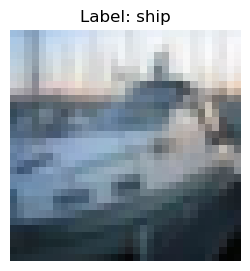

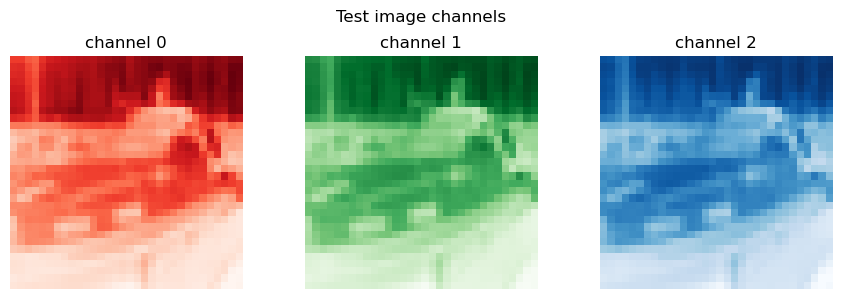

Predicted class: automobile


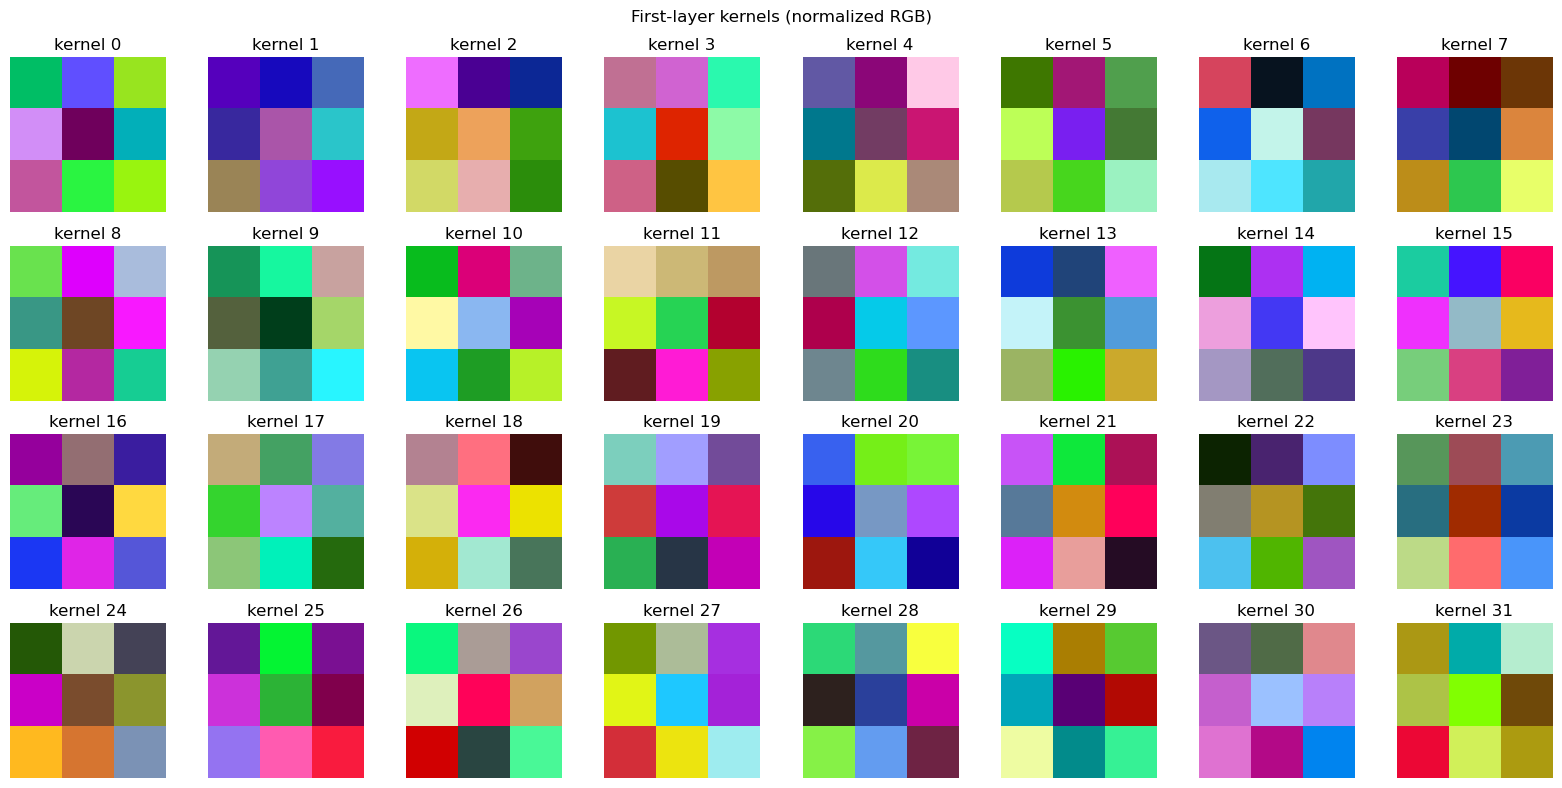

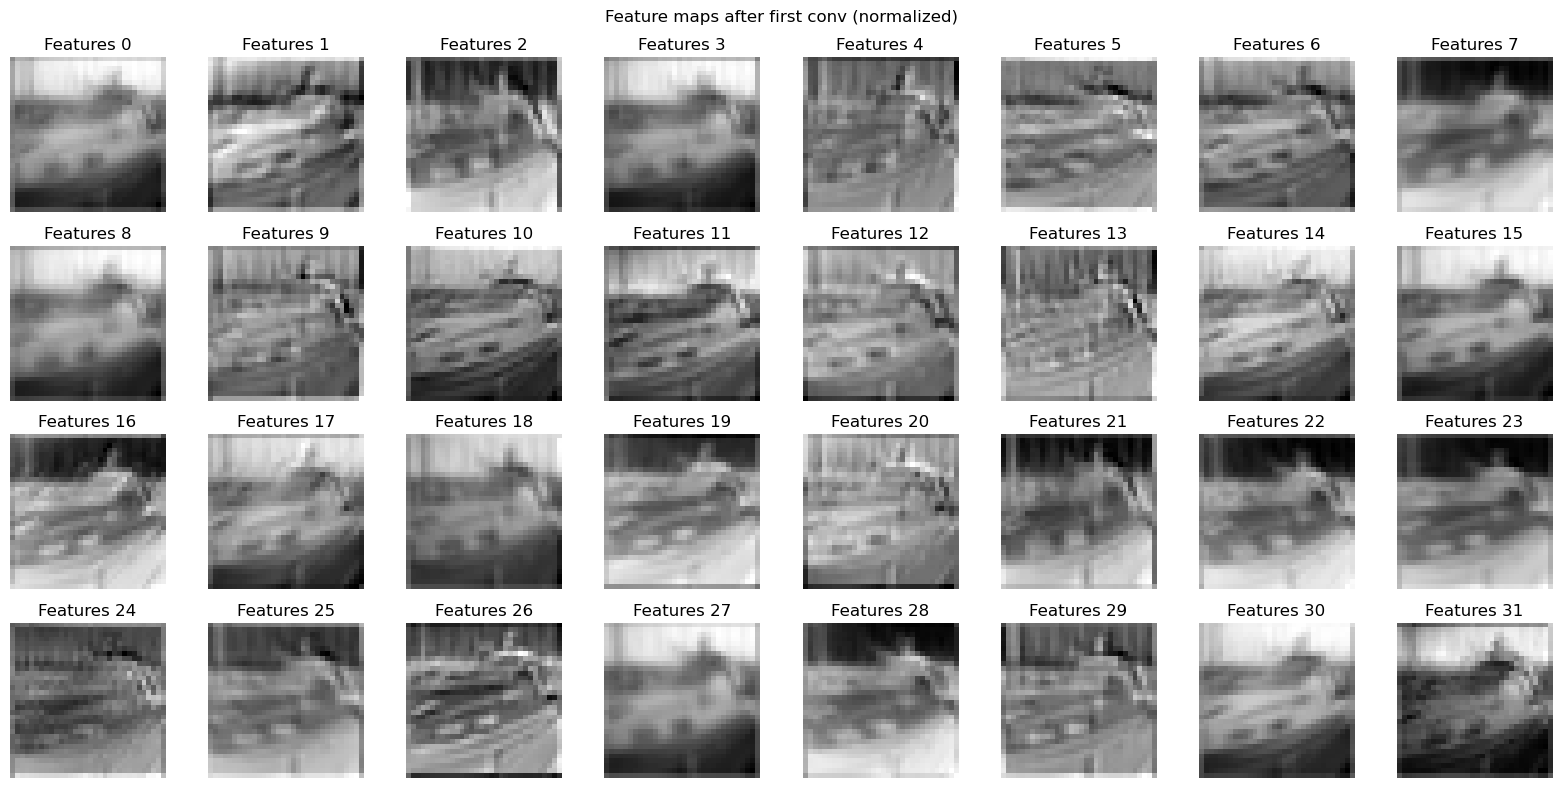

In [83]:
cnn_dropout.eval()
plot_filters(cnn_dropout, test_dl, i_img=2)

# Skip connections

In [ ]:
# Skip connections
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2) if downsample else nn.Identity()

    def forward(self, x):
        pass


class CNN_skip(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        channels = [3, 32, 64, 128, 128, 256]
        downsamples = {1, 3, 4}  # same downsampling pattern as before
        blocks = []
        for i in range(5):
            in_ch, out_ch = channels[i], channels[i + 1]
            down = i in downsamples
            blocks.append(ResidualBlock(in_ch, out_ch, downsample=down))
        self.features = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [ ]:
param_name = "skip"
cnn_skip = CNN_dropout().to(device)

opt = torch.optim.Adam(cnn_skip.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(
    cnn_skip, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0
)

# Explicit regularization

In [ ]:
def l1norm(model):
    # YOUR CODE HERE
    return


def l2norm(model):
    # YOUR CODE HERE
    return


def train_reg(
    model,
    train_dl,
    opt,
    criterion,
    writer,
    n_epochs,
    name="",
    reg="l1",
    global_step=0,
    prints=False,
):
    for epoch in range(n_epochs):
        for imgs, labels in train_dl:
            global_step += 1
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            logits = model(imgs)
            unreg_loss = criterion(logits, labels)
            if reg == "l1":
                # YOUR CODE HERE
                penalty = 0
            elif reg == "l2":
                # YOUR CODE HERE
                penalty = 0
            else:
                penalty = 0
            # YOUR CODE HERE
            loss = None
            writer.add_scalar("train/cnn_loss", unreg_loss.item(), global_step)
            if global_step % 100 == 0:
                log_grad_norms(model, writer, global_step, model_name=name)
            loss.backward()
            opt.step()
        print(f"Epoch {epoch + 1}: unregularized train loss = {unreg_loss.item():.4f}")
        print(f"Epoch {epoch + 1}: full train loss = {loss.item():.4f}")
        if prints:
            print(get_layer_grad_norms(model))
        test_model(model, test_dl, criterion, writer=None, global_step=None, name=name)

In [ ]:
param_name = "ell1_reg"
cnn = CNN_base().to(device)

opt = torch.optim.Adam(cnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train_reg(
    cnn, train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0
)

In [ ]:
@torch.no_grad()
def plot_weights_histogram(model):
    model_weights = []
    for p in model.parameters():
        model_weights.append(p.view(-1).abs())

    model_weights = torch.cat(model_weights).numpy()

    plt.hist(model_weights, bins=100)
    plt.show()


cnn_init = CNN_base().to(device)


plot_weights_histogram(cnn_init)
plot_weights_histogram(cnn)

# Data augmentation

Apply some random transformations to training images, 
e.g. 
transforms.RandomHorizontalFlip()
transforms.RandomRotation()
transforms.ColorJitter()

check [https://pytorch.org/vision/stable/transforms.html](torchvision transforms) 

In [ ]:
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision.transforms as T

train_transforms = transforms.Compose(
    [
        # YOUR CODE HERE
    ]
)


# We want to augment only our subset of data for fair comparison
class AugmentedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


n_train = 200
train_subset = Subset(trainset, list(range(n_train)))

augmented_subset = AugmentedSubset(train_subset)
aug_train_dl = DataLoader(augmented_subset, batch_size=32, shuffle=True)


In [ ]:
param_name = "ell1_reg"
cnn = CNN_base().to(device)

opt = torch.optim.Adam(cnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
global_step = 0

n_epochs = 50

train(
    cnn, aug_train_dl, opt, criterion, writer, n_epochs, name=param_name, global_step=0
)

Epoch 1: train loss = 2.3515
Test accuracy: 10.00%, test loss: 2.3001904487609863
Epoch 2: train loss = 2.2516
Test accuracy: 10.00%, test loss: 2.2943217754364014
Epoch 3: train loss = 2.0315
Test accuracy: 10.01%, test loss: 2.2843575477600098
Epoch 4: train loss = 2.2184
Test accuracy: 11.42%, test loss: 2.2363505363464355
Epoch 5: train loss = 2.2361
Test accuracy: 18.91%, test loss: 2.1686460971832275
Epoch 6: train loss = 1.9335
Test accuracy: 24.47%, test loss: 2.137650489807129
Epoch 7: train loss = 1.7620
Test accuracy: 22.81%, test loss: 2.1386733055114746
Epoch 8: train loss = 1.7518
Test accuracy: 26.12%, test loss: 2.133864402770996
Epoch 9: train loss = 1.1876
Test accuracy: 24.52%, test loss: 2.236203193664551
Epoch 10: train loss = 1.4397
Test accuracy: 25.56%, test loss: 2.301499366760254
Epoch 11: train loss = 1.6409
Test accuracy: 24.36%, test loss: 2.3946194648742676
Epoch 12: train loss = 1.6840
Test accuracy: 25.01%, test loss: 2.516458511352539
Epoch 13: train lo

# Do you own experiments!
Try to achieve the best possible test accuracy on CIFAR10 with these 200 points. 
You can use any of the tricks seen in this TP or others you may know of.

Add more data points to the training set and see how the different tricks scale with more data.

# Learning rate scheduling illustration

In [ ]:
import torch
import matplotlib.pyplot as plt

T = 200
base_lr = 1e-3


def make_optimizer():
    model = torch.nn.Linear(10, 1)
    return torch.optim.Adam(model.parameters(), lr=base_lr)


optimizers = {name: make_optimizer() for name in range(5)}

schedulers = {
    "Constant": torch.optim.lr_scheduler.LambdaLR(make_optimizer(), lambda _: 1.0),
    "StepLR": torch.optim.lr_scheduler.StepLR(
        make_optimizer(), step_size=50, gamma=0.5
    ),
    "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR(
        make_optimizer(), gamma=0.98
    ),
    "CosineAnnealingLR": torch.optim.lr_scheduler.CosineAnnealingLR(
        make_optimizer(), T_max=T
    ),
    "OneCycleLR": torch.optim.lr_scheduler.OneCycleLR(
        make_optimizer(), max_lr=1e-3, total_steps=T
    ),
}

# Record learning rates
lrs = {name: [] for name in schedulers}

for step in range(T):
    for param_name, sched in schedulers.items():
        opt = sched.optimizer
        lrs[param_name].append(opt.param_groups[0]["lr"])
        sched.step()

plt.figure(figsize=(7, 4))
for param_name, values in lrs.items():
    plt.plot(values, label=param_name)
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Typical Learning Rate Schedulers in PyTorch")
plt.legend()
plt.tight_layout()
plt.show()